<a href="https://colab.research.google.com/github/nsrnkha/UAS-PCD/blob/main/Image_Processing_Shape_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Statements**

In [ ]:
 
# Import statements
 
import tensorflow as tf
import pandas as pd
import numpy as np
import cv2
import os
import shutil
from zipfile import ZipFile
import matplotlib.pyplot as plt
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns


# **Split dataset into Train, Validation & Test sets**

In [ ]:
 
# Split dataset into Train, Validation & Test sets

parent_folder = '../input/basicshapes/shapes/shapes'
size = 75   # Resize all images to (size,size)
bs = 32      # Batch size


# Data augmentation on train dataset only
train_data_gen = ImageDataGenerator(width_shift_range = 0.1, height_shift_range = 0.1, zoom_range=0.1, shear_range=0.1, brightness_range=[0.8,1.2], validation_split=0.15, preprocessing_function=preprocess_input)
train_data = train_data_gen.flow_from_directory(parent_folder, class_mode='categorical', target_size=(size,size), color_mode='rgb', batch_size=bs, seed=42, subset='training')

validation_data_gen = ImageDataGenerator(validation_split=0.15, preprocessing_function=preprocess_input)
validation_data = validation_data_gen.flow_from_directory(parent_folder, class_mode='categorical', target_size=(size,size), color_mode='rgb', batch_size=bs, seed=42, subset='validation')

test_data_gen = ImageDataGenerator(validation_split=0.10, preprocessing_function=preprocess_input)
test_data = test_data_gen.flow_from_directory(parent_folder, class_mode='categorical', target_size=(size,size), color_mode='rgb', subset='validation', shuffle=False)


Found 255 images belonging to 3 classes.
Found 45 images belonging to 3 classes.
Found 30 images belonging to 3 classes.


# **Assign essential variables**

In [ ]:

# Assign essential variables

shape = train_data.image_shape                
print(shape)
k = train_data.num_classes                    
train_samples = train_data.samples             
validation_samples = validation_data.samples  


(75, 75, 3)


# **Build the model**

In [ ]:
# Build the model

 
input = Input(shape=shape)
 
basemodel = InceptionV3(include_top=False, weights='imagenet', input_shape=shape, pooling='avg')  
basemodel.trainable = False                                                                       
 
x = basemodel(input)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
output = Dense(k, activation='softmax')(x)
 
model = Model(input,output)
 

87916544/87910968 [==============================] - 1s 0us/step


# **Compile the model**

In [ ]:

# Compile the model

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


# **Initialize callbacks**

In [ ]:
 
# Initialize callbacks
 
stop = EarlyStopping(monitor='val_loss', patience=4, mode='min', restore_best_weights=True)                                             
checkpoint = ModelCheckpoint(filepath='{val_loss:.4f}-weights-{epoch:02d}.hdf5', monitor='val_loss', mode='min', save_best_only=True)   


# **Model Summary**

In [ ]:

# Model Summary

model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 75, 75, 3)]       0         
_________________________________________________________________
inception_v3 (Functional)    (None, 2048)              21802784  
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 3075      
Total params: 23,904,035
Trainable params: 2,101,251
Non-trainable params: 21,802,784
_________________________________________________________________


# **Train the model**

In [ ]:

# Train the model

ep = 50                     
spe = train_samples/bs       
vs = validation_samples/bs  
 
r = model.fit(train_data, validation_data=validation_data, steps_per_epoch=spe, validation_steps=vs, epochs=ep, callbacks=[stop,checkpoint])


Epoch 1/50
7/7 [==============================] - 15s 616ms/step - loss: 0.5843 - accuracy: 0.7276 - val_loss: 0.0904 - val_accuracy: 0.9556
Epoch 2/50
7/7 [==============================] - 1s 107ms/step - loss: 0.0091 - accuracy: 0.9980 - val_loss: 0.3172 - val_accuracy: 0.9556
Epoch 3/50
7/7 [==============================] - 1s 108ms/step - loss: 0.0046 - accuracy: 0.9980 - val_loss: 0.2450 - val_accuracy: 0.9556
Epoch 4/50
7/7 [==============================] - 1s 112ms/step - loss: 0.0222 - accuracy: 0.9898 - val_loss: 0.1662 - val_accuracy: 0.9556
Epoch 5/50
7/7 [==============================] - 1s 113ms/step - loss: 0.0080 - accuracy: 1.0000 - val_loss: 0.2973 - val_accuracy: 0.9556


# **Evaluate the model**

In [ ]:
 
# Evaluate the model
 
model.evaluate(validation_data)


2/2 [==============================] - 0s 18ms/step - loss: 0.0904 - accuracy: 0.9556


[0.09042235463857651, 0.9555555582046509]

# **Plot training history**

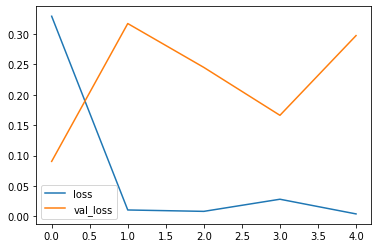

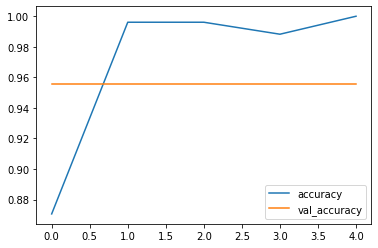

In [ ]:

# Plot training history
 
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()
plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()


# **Predictions on the test data**

In [ ]:

# Predictions on the test data

pred = model.predict(test_data).argmax(axis=1)
labels = list(train_data.class_indices.keys())


# **Get the F1 score on test data prediction**

In [ ]:

# Get the F1 score on test data prediction

print(classification_report(test_data.classes, pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.83      1.00      0.91        10
           2       1.00      0.80      0.89        10

    accuracy                           0.93        30
   macro avg       0.94      0.93      0.93        30
weighted avg       0.94      0.93      0.93        30



# **Plot confusion matrix**

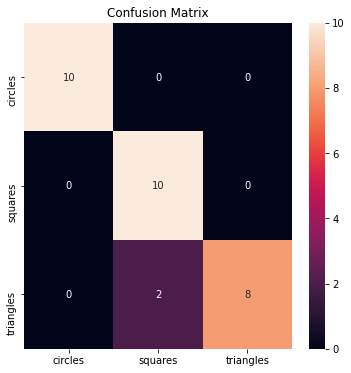

In [ ]:

# Plot confusion matrix

n = (test_data.num_classes)*2

cm = confusion_matrix(test_data.classes, pred)
plt.figure(figsize=(n,n))
sns.heatmap(cm, annot=True, fmt='g', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.show()


# **Visualize random predictions on the test data**

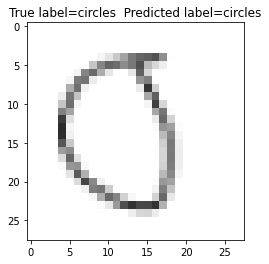

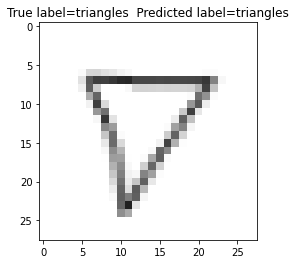

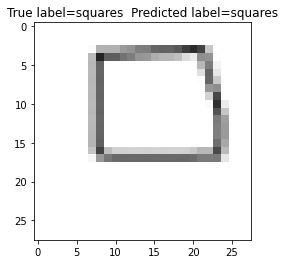

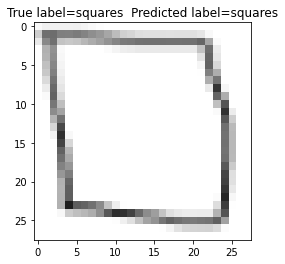

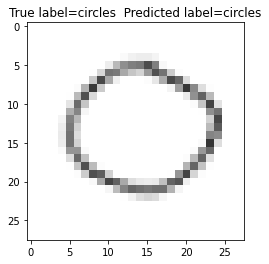

In [ ]:

# Visualize random predictions on the test data

rand = np.random.randint(low=0, high=test_data.samples, size=5)

for n in rand:
  true_index = test_data.classes[n]
  predicted_index = pred[n]
  img = cv2.imread(test_data.filepaths[n])
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  plt.imshow(img)
  plt.title('True label={}  Predicted label={}'.format(labels[true_index], labels[predicted_index]))
  plt.show()
